In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM,EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm.notebook import trange, tqdm
import subprocess
import os
import shutil

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:



model_no_bar = torch.load("out/new_dataset/Nvidia_model_bz_128_lr_0.001_ep_30/model_ep_9.pth").to(device)


model_bar = torch.load("out/new_dataset/Nvidia_bar_model_resized_cons_bz_128_lr_0.0001_ep_30/model_ep_27.pth").to(device)


model_brown = torch.load("out/new_dataset/style_transfer/Nvidia_model_bz_128_lr_0.001_ep_30/style_green/model_ep_24.pth").to(device)
model_green = torch.load("out/new_dataset/style_transfer/Nvidia_model_bz_128_lr_0.001_ep_30/style_brown/model_ep_6.pth").to(device)
model_mixed = torch.load("out/new_dataset/style_transfer/Nvidia_model_bz_128_lr_0.001_ep_30/style_mixed/model_ep_0.pth").to(device)

In [4]:
model_no_bar

Nvidia_model(
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 36, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(36, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu5): ReLU()
  (maxpool5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=100, bias=True)
  (relu6): ReLU()
  (fc2): Linear(in

In [5]:
#data = np.load("../runs/New_runs_with_car_corrected/2021-06-30 22:42:45.586516/discrete_histories.npz")

In [6]:
data = np.load("../runs/Style_trasnfer/2021-07-04 17:27:49.796952/style_transf_histories.npz")

In [7]:
data.files

['r_history',
 'input_history',
 'frames',
 'fps',
 'car_frames',
 'style_0',
 'style_1']

In [8]:
frames_0 = data['style_0'][::10]
frames_1 = data['style_1'][::10]
frames = data['car_frames'][::10]
frames.shape

(86, 288, 256, 3)

Text(0.5, 1.0, 'frames')

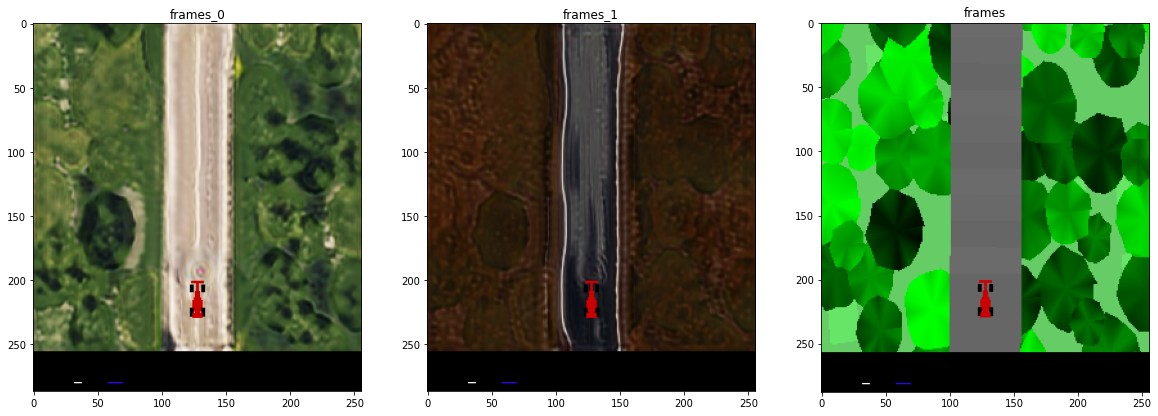

In [9]:
f, axarr = plt.subplots(1,3, figsize=(20,10))
axarr[0].imshow(frames_0[0])
axarr[0].set_title("frames_0")
axarr[1].imshow(frames_1[0])
axarr[1].set_title("frames_1")
axarr[2].imshow(frames[0])
axarr[2].set_title("frames")



In [14]:
def Grad_cam_evaal(cam_fun,name):
    def get_grad(frames, dim, model, target_layer):
        model.eval()
        aux_frames = np.copy(frames[:,:dim,...])
        rgb_imgs = np.copy(aux_frames)
        rgb_imgs = rgb_imgs/255
        aux_frames = np.transpose(aux_frames, axes=[0, 3, 1, 2])
        aux_frames = (2 * (aux_frames / 255)) - 1

        input_tensor = torch.from_numpy(aux_frames)
        input_tensor = input_tensor.type(torch.float)
        dirs = np.array(['Left', 'Right', 'Accelerate', 'Brake'])
        titles = dirs[model(input_tensor.to(device)).argmax(1).cpu().numpy()]
        cam = cam_fun(model=model, target_layer=target_layer, use_cuda=True)

        grad_cam = np.array([cam(input_tensor=input_tensor, target_category=None)]+[cam(input_tensor=input_tensor, target_category=i) for i in range(4)])
        print(rgb_imgs[0].shape)
        print(rgb_imgs[0].dtype)
        visualization = np.array([[show_cam_on_image(rgb_imgs[i], gd[i], use_rgb=True) for i in range(grad_cam.shape[1])] for gd in grad_cam])
        return visualization, titles

    OpenAI_vis_nb, titles_OpenAI_vis_nb = get_grad(frames, 256, model_no_bar, model_no_bar.conv5)
    OpenAI_vis_bar, titles_OpenAI_vis_bar = get_grad(frames, 288, model_bar, model_bar.conv4)
    brown_vis, titles_brown_vis = get_grad(frames_1, 256, model_brown, model_brown.conv5)
    brown_vis_mixed, titles_brown_vis_mixed = get_grad(frames_1, 256, model_mixed,model_mixed.conv5 )
    green_vis, titles_green_vis = get_grad(frames_0, 256, model_green,model_green.conv5 )
    green_vis_mixed, titles_green_vis_mixed =get_grad(frames_0, 256, model_mixed,model_mixed.conv5 )

    def plot_grads(n):

        fig, ax = plt.subplots(6,6, figsize=(30,20))
        fig.suptitle(f"GradCAM frame {n}")
        ax[0,0].imshow(frames[n][:256,:])
        ax[0,0].set_title("OpenAI no bar")
        ax[0,0].axis('off')

        ax[1,0].imshow(frames[n])
        ax[1,0].set_title("OpenAI bar")
        ax[1,0].axis('off')

        ax[2,0].imshow(frames_0[n][:256,:])
        ax[2,0].set_title("Style 0")
        ax[2,0].axis('off')

        ax[3,0].imshow(frames_0[n][:256,:])
        ax[3,0].set_title("Style 0 mixed")
        ax[3,0].axis('off')


        ax[4,0].imshow(frames_1[n][:256,:])
        ax[4,0].set_title("Style 1")
        ax[4,0].axis('off')

        ax[5,0].imshow(frames_1[n][:256,:])
        ax[5,0].set_title("Style 1 mixed")
        ax[5,0].axis('off')


        for j, (v,t) in enumerate(zip([ OpenAI_vis_nb, OpenAI_vis_bar, brown_vis, brown_vis_mixed, green_vis, green_vis_mixed],[titles_OpenAI_vis_nb,titles_OpenAI_vis_bar,titles_brown_vis,titles_brown_vis_mixed,titles_green_vis,titles_green_vis_mixed])):

            ax[j,1].imshow(v[0,n])
            ax[j,1].set_title(f"Predicted: {t[n]}")
            ax[j,1].axis('off')

        dirs =  ["Left", "Right", "Accelerate", "Brake"]
        for i,d in enumerate(dirs): 
            for j, (v,t) in enumerate(zip([ OpenAI_vis_nb, OpenAI_vis_bar, brown_vis, brown_vis_mixed, green_vis, green_vis_mixed],[titles_OpenAI_vis_nb,titles_OpenAI_vis_bar,titles_brown_vis,titles_brown_vis_mixed,titles_green_vis,titles_green_vis_mixed])):

                ax[j,2+i].imshow(v[1+i,n])
                ax[j,2+i].set_title(d)
                ax[j,2+i].axis('off')
        plt.tight_layout()

        return fig
    def make_vid(frms, name):
        if not os.path.exists("Images"):
            os.makedirs("Images")
        for n in trange(0,frms):
            fig = plot_grads(n);
            plt.savefig("Images/frame"+str(n));
            plt.close(fig)
        os.chdir("Images")
        subprocess.call(['ffmpeg','-framerate', '2' ,'-i', 'frame%1d.png','-s', '1920x1080','-vcodec', 'libx265', '-crf', '28', f"../Videos/{name}.mp4", '-y'])
        os.chdir("..")

        try:
            shutil.rmtree("Images")
        except OSError as e:
            print("Error: %s : %s" % ("Images", e.strerror))

    make_vid(86, name)

/home/lh/miniconda3/envs/DL_CAR/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/lh/miniconda3/envs/DL_CAR/lib/python3.8/site-packages/pytorch_grad_cam/base_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)


(256, 256, 3)
float64
(288, 256, 3)
float64
(256, 256, 3)
float64
(256, 256, 3)
float64
(256, 256, 3)
float64
(256, 256, 3)
float64


KeyboardInterrupt: 

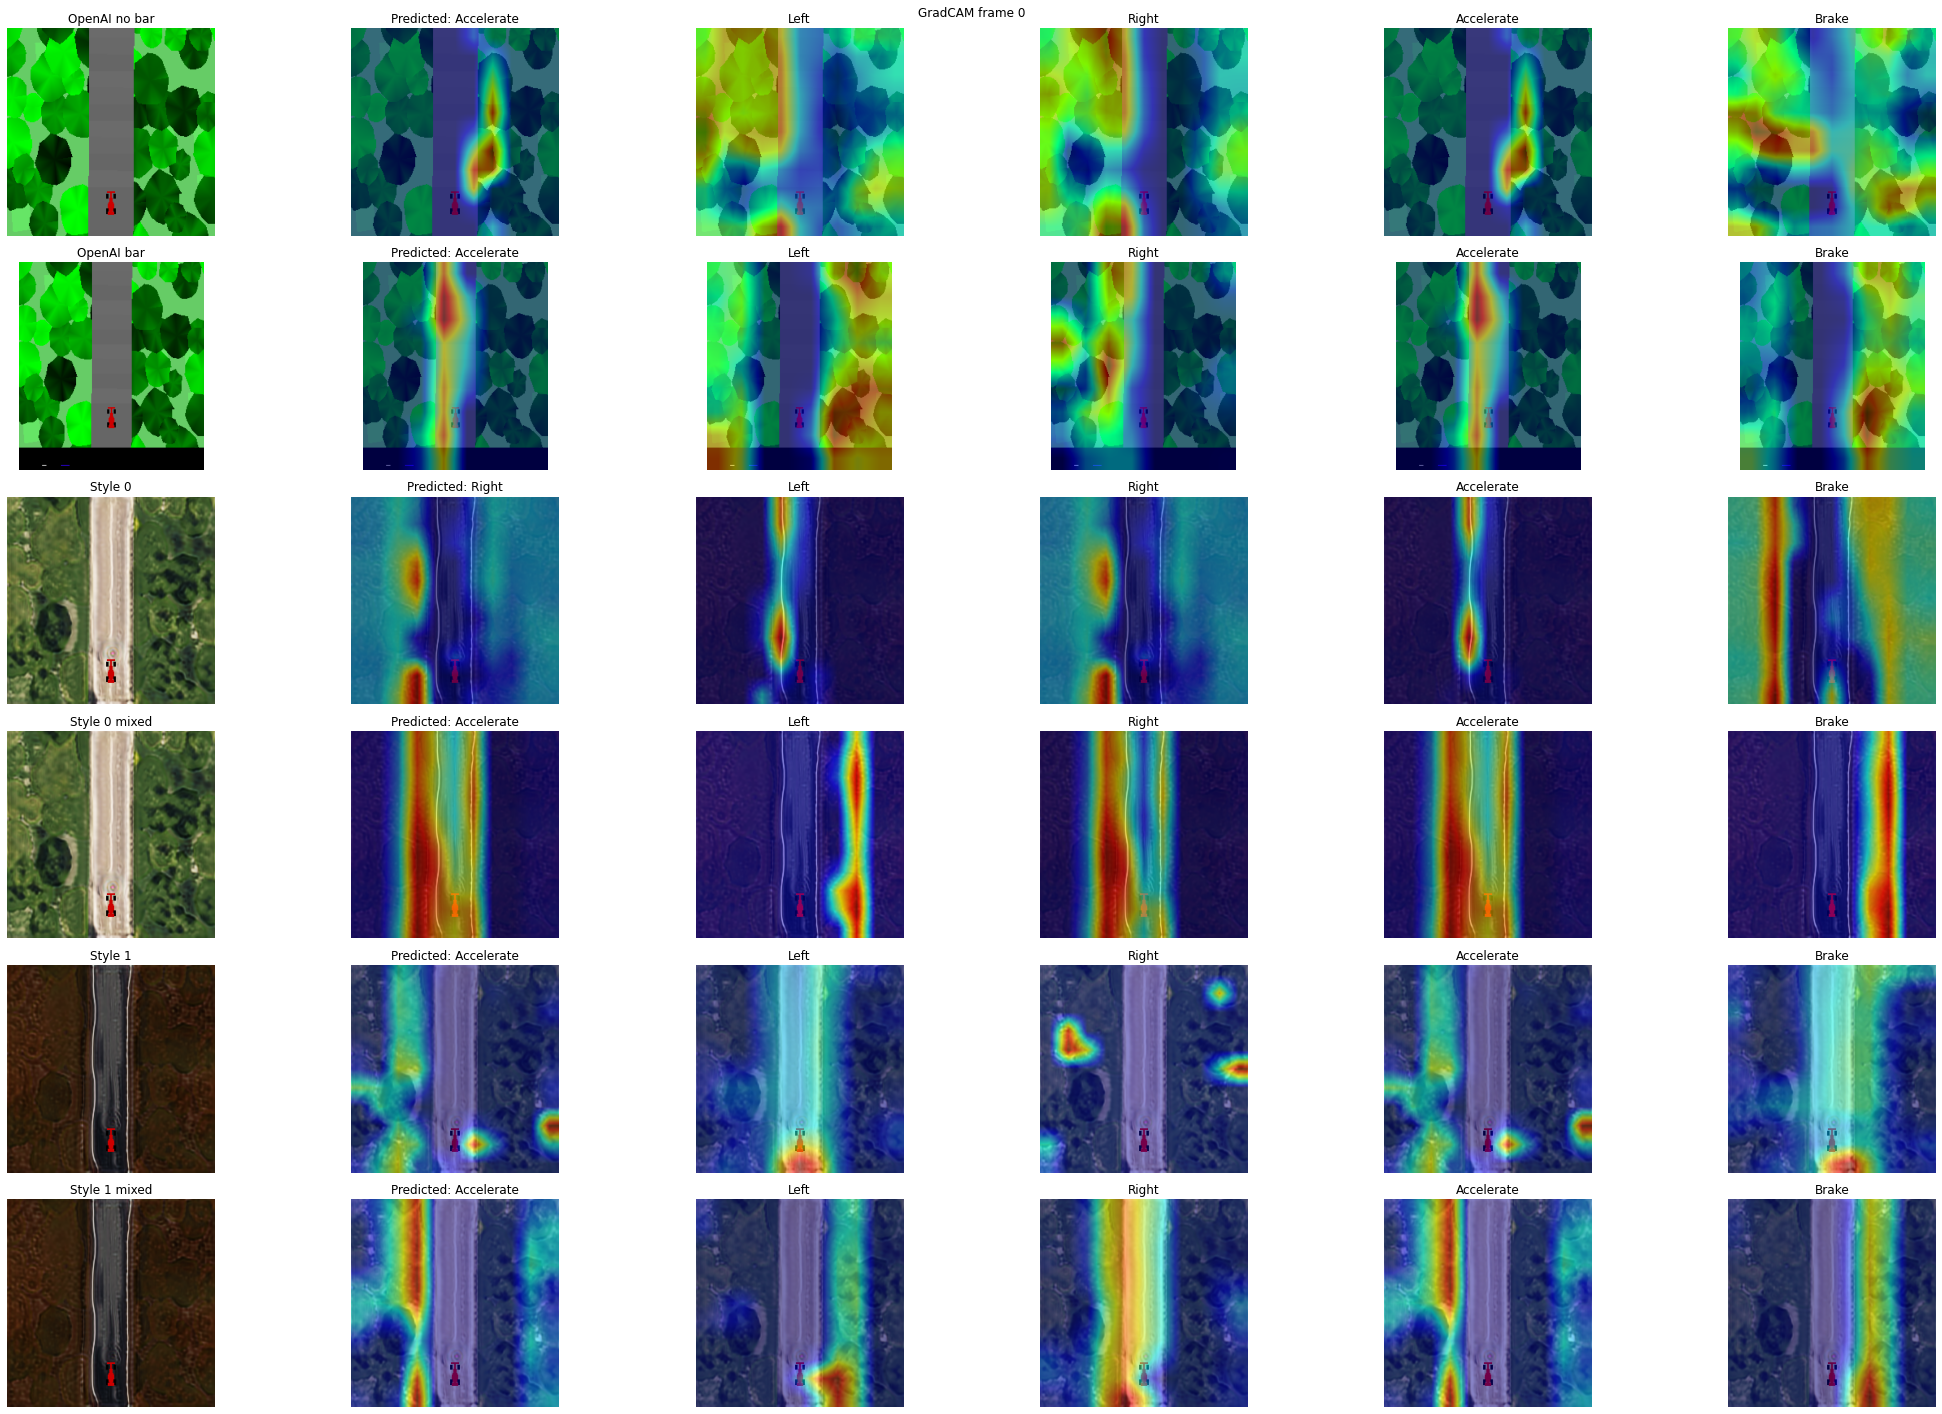

In [15]:
Grad_cam_evaal(GradCAM,"GradCAM")


In [12]:
Grad_cam_evaal(GradCAMPlusPlus,"GradCAMPlusPlus")

/home/lh/miniconda3/envs/DL_CAR/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/lh/miniconda3/envs/DL_CAR/lib/python3.8/site-packages/pytorch_grad_cam/base_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)


In [13]:
Grad_cam_evaal(XGradCAM,"XGradCAM")

/home/lh/miniconda3/envs/DL_CAR/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/lh/miniconda3/envs/DL_CAR/lib/python3.8/site-packages/pytorch_grad_cam/base_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)


In [14]:
Grad_cam_evaal(EigenCAM,"EigenCAM")

/home/lh/miniconda3/envs/DL_CAR/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/home/lh/miniconda3/envs/DL_CAR/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


KeyboardInterrupt: 

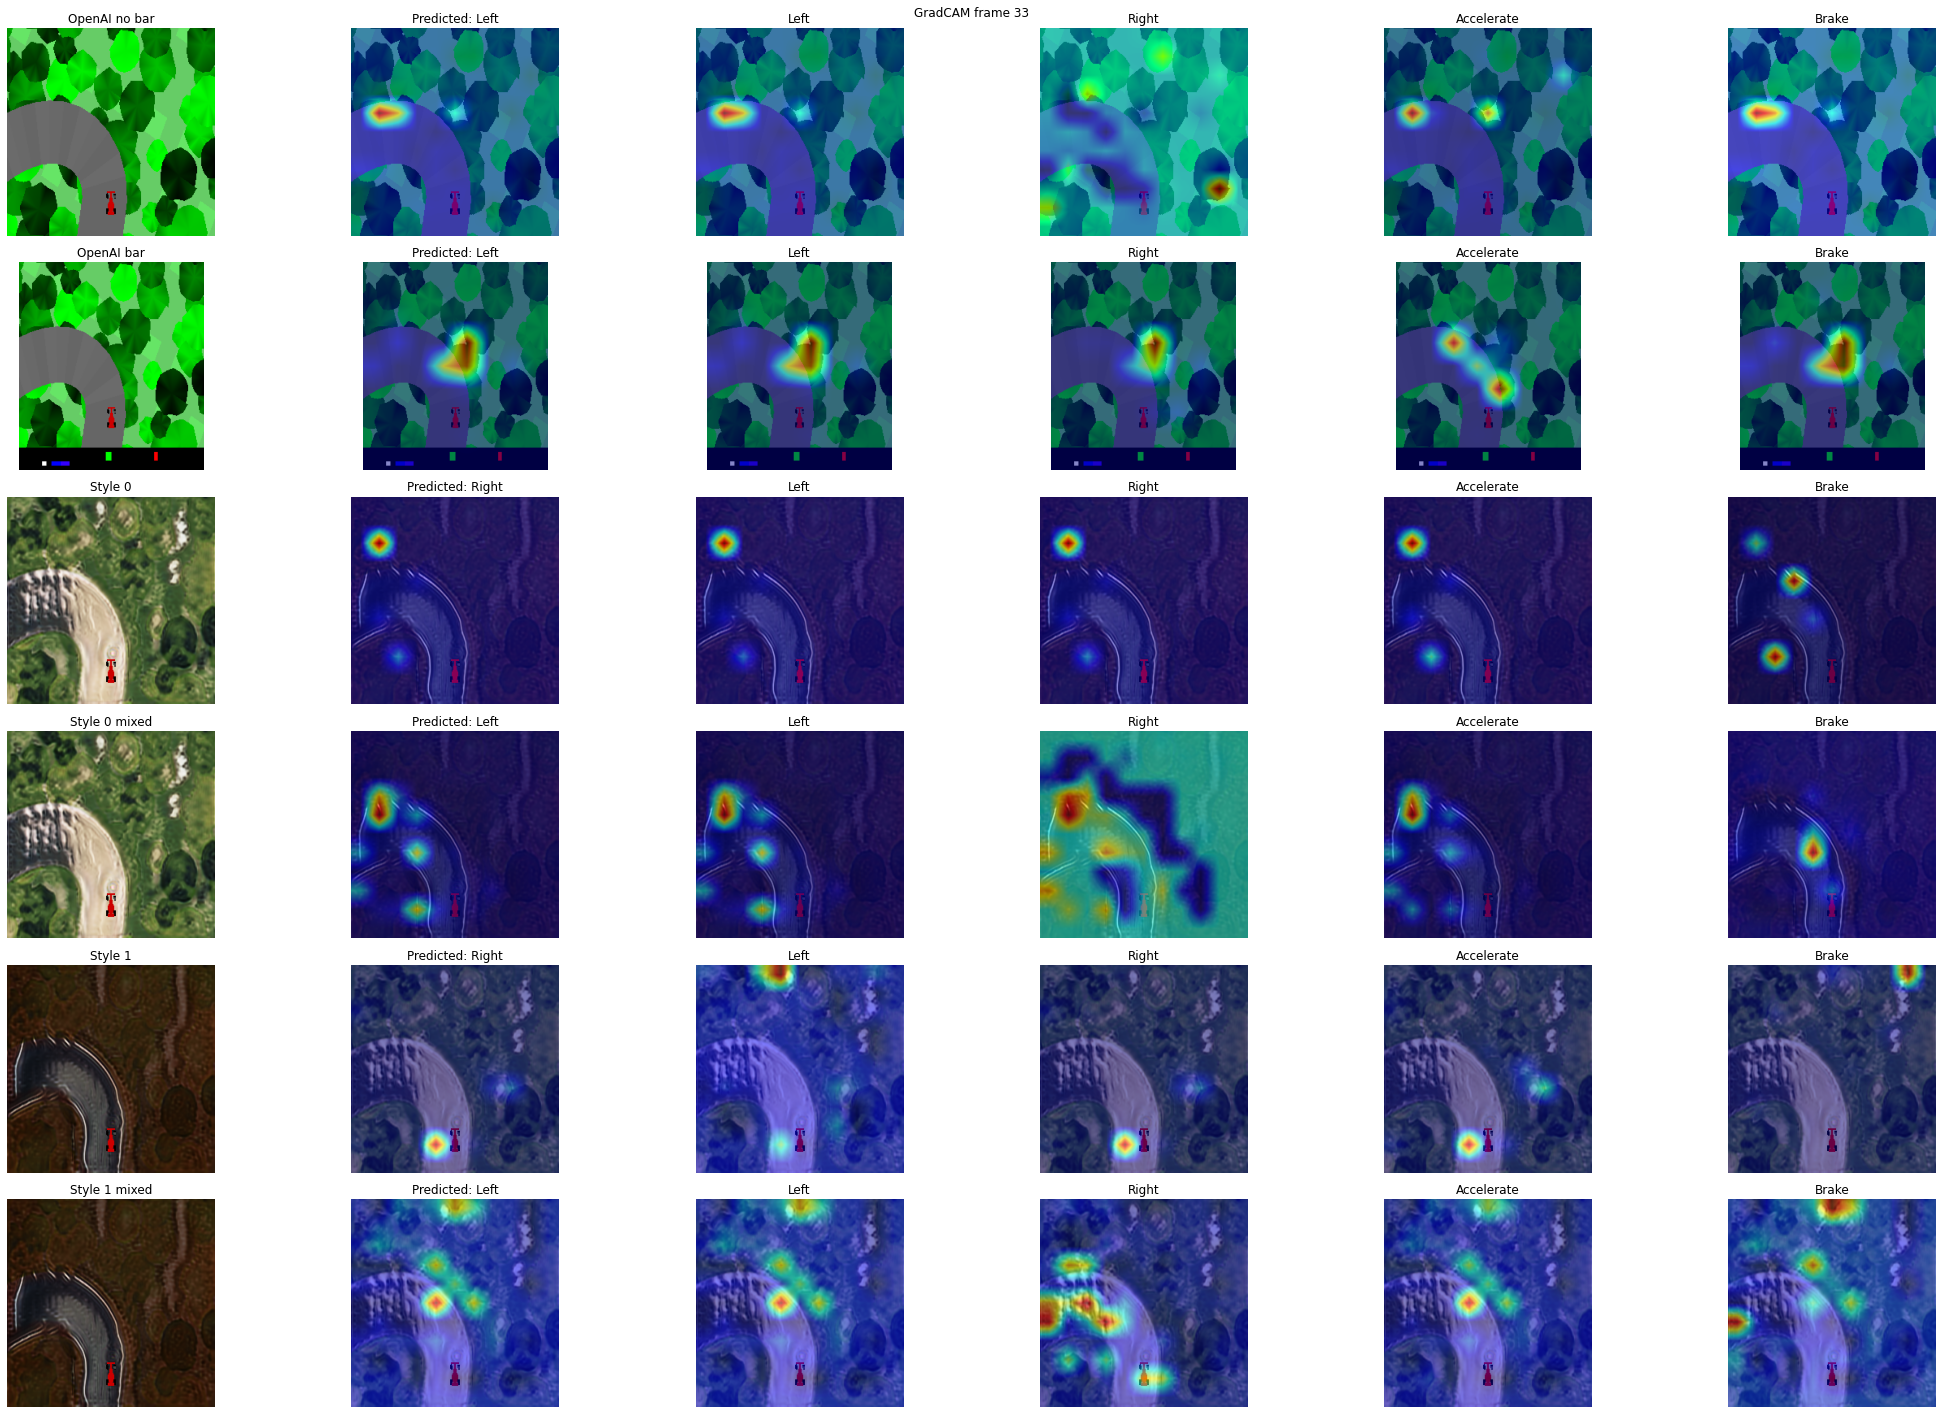

In [15]:
Grad_cam_evaal(EigenGradCAM,"EigenGradCAM")